In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import gpytorch as gp
from botorch.models import FixedNoiseGP, SingleTaskGP
from botorch.fit import fit_gpytorch_model
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

from fixed_noise_gp import get_gp, train_gp, predict

In [4]:
df = pd.read_csv('../data/copolymer/copolymer_data_all.csv')

In [5]:
X1 = np.array(df.loc[:,'x1']).astype(np.float64)
X2 = np.array(df.loc[:,'x2']).astype(np.float64)
X = np.vstack((X1, X2)).T

X = torch.from_numpy(X).to(torch.float64)

Y = np.array(df.loc[:,'rg_mean'])
Y = torch.from_numpy(Y).to(torch.float64).unsqueeze(-1)

noise = np.array(np.square(df.loc[:,'rg_std']))
noise = torch.from_numpy(noise).to(torch.float64).unsqueeze(-1)

In [6]:
torch.manual_seed(42)
n = X.shape[0]
perm = torch.randperm(n)
train_idx = perm[:25]
test_idx = perm[25:]

In [7]:
train_X = X[train_idx]
train_Y = Y[train_idx]
train_noise = noise[train_idx]

test_X = X[test_idx]
test_Y = Y[test_idx]
test_noise = noise[test_idx]

In [8]:
test_df = df.iloc[test_idx]

In [9]:
model = get_gp(train_X, train_Y, train_noise)
model = train_gp(model)

In [10]:
with torch.no_grad():
    posterior = model.posterior(test_X)
    pred_mean = posterior.mean.squeeze()
    pred_var = posterior.variance.squeeze()

In [11]:
def plot_ypred_vs_ytrue(ypred, ytrue):
    plt.figure(figsize=(8, 8))
    plt.scatter(ytrue, ypred, alpha=0.6)
    plt.xlabel('True', fontsize=20)
    plt.ylabel('Predicted', fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
    plt.show()

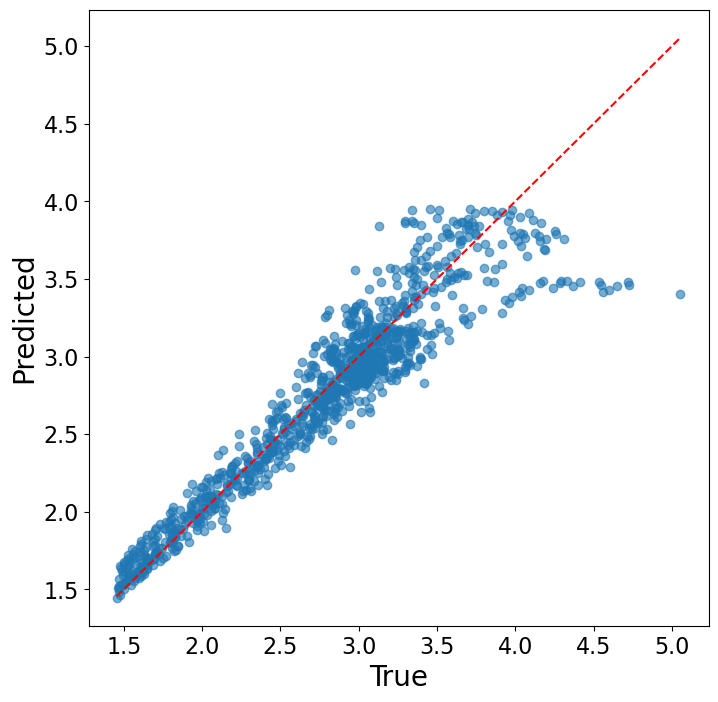

In [12]:
plot_ypred_vs_ytrue(pred_mean.detach().numpy(), test_Y)

In [13]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_Y, pred_mean.detach().numpy())
rmse = np.sqrt(mean_squared_error(test_Y, pred_mean.detach().numpy()))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.8851
RMSE: 0.2281


In [14]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [15]:
data = np.column_stack((test_Y.detach().numpy(), pred_mean.detach().numpy(), np.sqrt(pred_var.detach().numpy())))

df = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])
df['error'] = df['pred_y'] - df['test_y']

In [16]:
df

,test_y,pred_y,uq,error
0,2.448029,2.697461,0.084289,0.249432
1,2.831312,2.824689,0.088561,-0.006623
2,3.158686,2.971371,0.058860,-0.187315
3,3.328809,2.948095,0.248557,-0.380714
4,2.945838,3.008685,0.157073,0.062848
...,...,...,...,...
990,4.020607,3.742210,0.130437,-0.278397
991,2.744313,2.681114,0.114463,-0.063199
992,2.536614,2.698411,0.086315,0.161798
993,2.938480,3.085032,0.080951,0.146552


rho_rank = 0.27
rho_rank_sim = 0.45 +/- 0.03
miscalibration area = 0.14
NLL = 0.47
NLL_sim = -0.86 +/- 0.02
R squared: 0.5453806141291148
intercept: 0.08581559103100064
slope: 0.977819328128896


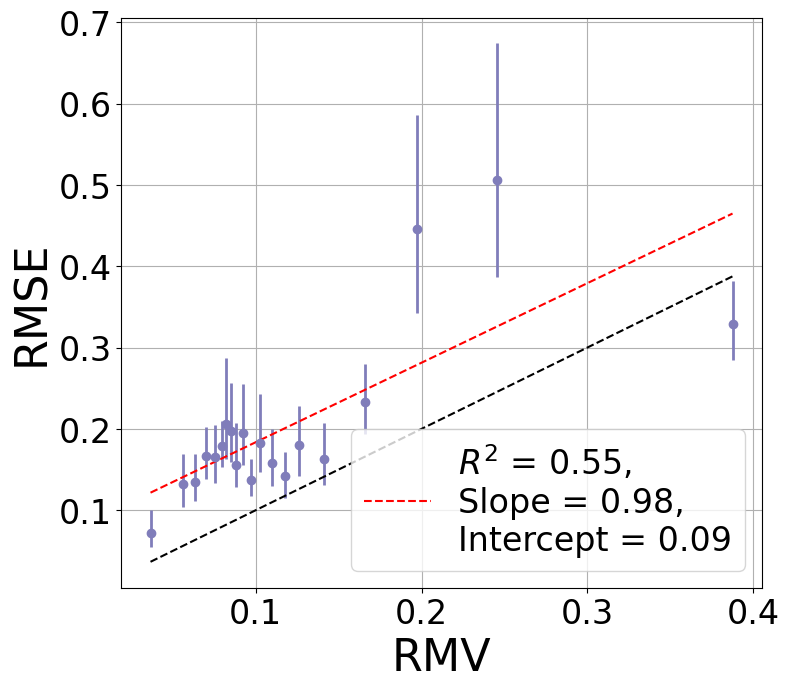

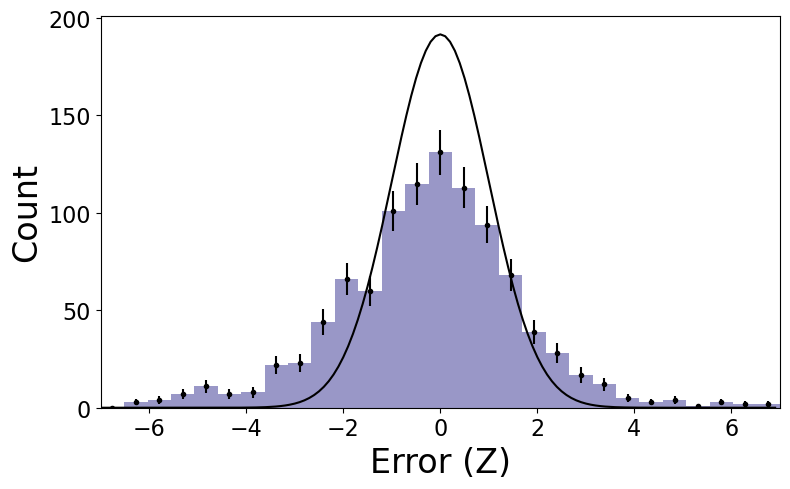

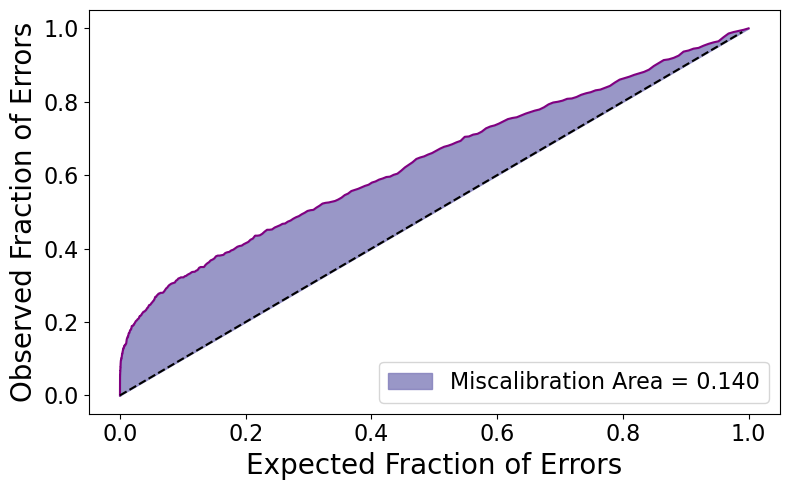

In [17]:
#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(df.uq, df.error)

#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(df.error), df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(df.uq, df.error)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

#Generate error-based calibration plot
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)